In [2]:
import pandas as pd
import numpy as np

def analyze_and_save_windows(prices, ticker="SIM", save_files=True):
    # 1. Setup
    HORIZONS = 5 * (np.arange(26) + 1)
    ret = np.diff(np.log(prices))
    scale = np.sqrt(252)
    
    all_dfs = []

    # 2. Vectorized Window Processing
    for T in HORIZONS:
        # Calculate how many full windows of size T fit in the data
        n_windows = len(ret) // T
        if n_windows == 0:
            continue
            
        # Truncate and reshape to (n_windows, T)
        # This effectively "slices" all windows at once
        windows = ret[:n_windows * T].reshape(n_windows, T)
        
        # Vectorized calculations across axis 1 (the window)
        sums = windows.sum(axis=1)
        sigmas = windows.std(axis=1, ddof=0) * scale
        z_raws = sums / np.sqrt(T / 252.0)
        
        # Create a temporary dataframe for this Horizon T
        # (Appending to a list of DFs is faster than appending dictionaries to a list)
        horizon_df = pd.DataFrame({
            "ticker": ticker,
            "date": (np.arange(1, n_windows + 1) * T),
            "T": T,
            "z_raw": z_raws,
            "sigma": sigmas
        })
        all_dfs.append(horizon_df)

    if not all_dfs:
        return None

    df = pd.concat(all_dfs, ignore_index=True)

    # 3. Filtering and De-meaning
    # Filter for finite and positive sigma in one go
    mask = np.isfinite(df['z_raw']) & np.isfinite(df['sigma']) & (df['sigma'] > 0)
    df = df[mask].copy()
    
    # Vectorized global de-meaning
    df["z"] = df["z_raw"] - df.groupby(["ticker", "T"])["z_raw"].transform("mean")
    df = df.drop(columns="z_raw").reset_index(drop=True)

    # 4. Exporting (Logic remains the same but slightly more efficient)
    if save_files:
        n = len(df) // 3
        if n > 0:
            df.iloc[:n].to_parquet("dataset_part1.parquet")
            df.iloc[n:2*n].to_parquet("dataset_part2.parquet")
            df.iloc[2*n:].to_parquet("dataset_part3.parquet")
            print(f"Saved {len(df)} windows for ticker: {ticker}")

        if len(prices) == 100000:
            pd.DataFrame({"Day": np.arange(1, len(prices) + 1), "Price": prices}).to_csv("simulated_prices.csv", index=False)
            print("Saved 100k prices to simulated_prices.csv")

    return df

------------------------------
Fitting GARCH(1,1)...
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -32318.3
Distribution:                  Normal   AIC:                           64644.5
Method:            Maximum Likelihood   BIC:                           64676.9
                                        No. Observations:                24375
Date:                Fri, Jan 02 2026   Df Residuals:                    24374
Time:                        09:15:16   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu   

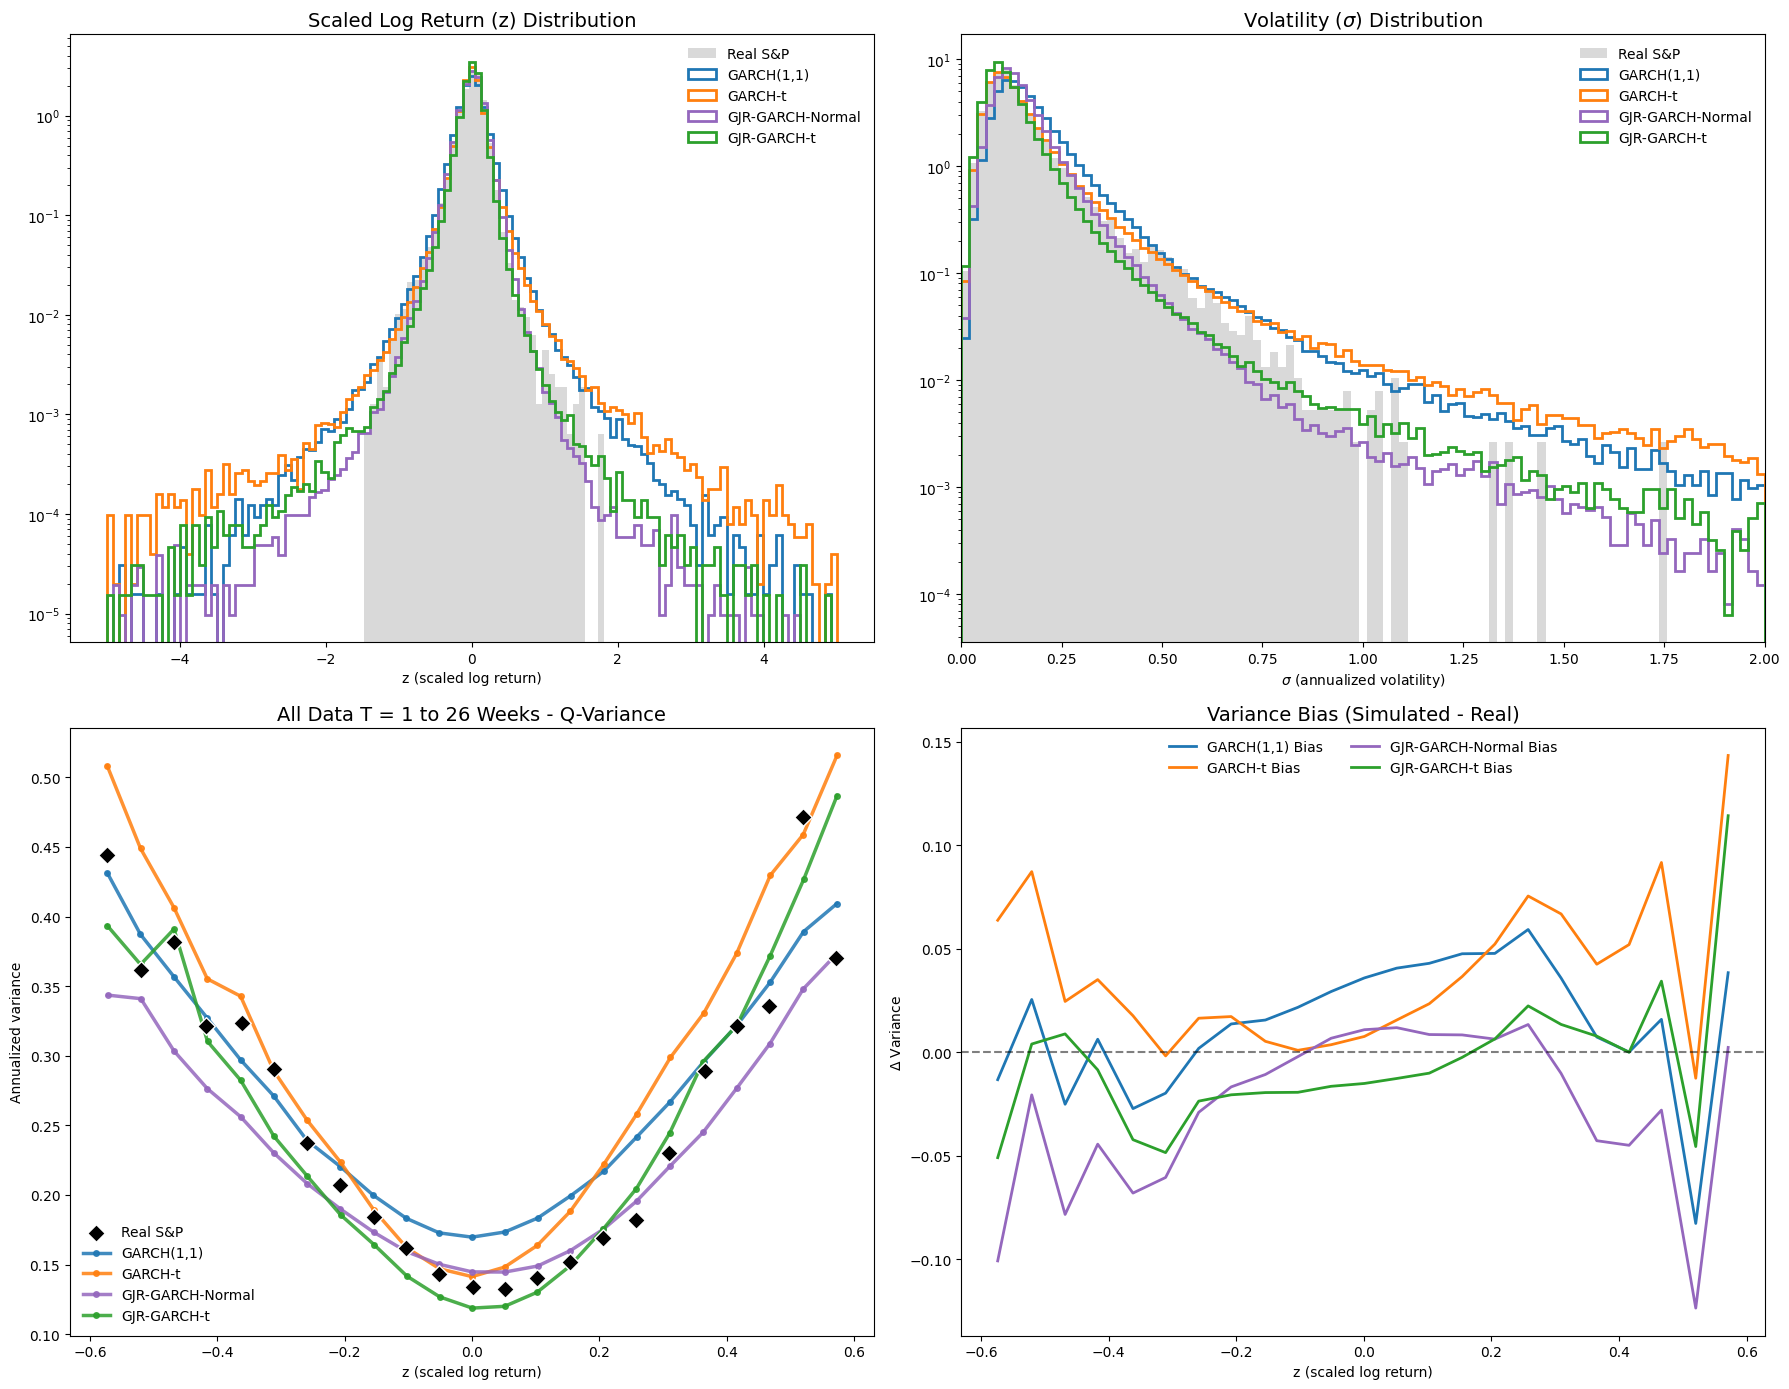

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

# --- 1. SETTINGS & COLORS ---
N_SIM = 5_000_000
colors = {
    'Real S&P':         '#000000', 
    'GARCH(1,1)':       '#1f77b4', 
    'GARCH-t':          '#ff7f0e', 
    'GJR-GARCH-Normal': '#9467bd', 
    'GJR-GARCH-t':      '#2ca02c'  
}

# --- 2. CORE FUNCTIONS ---

def get_binned_stats(df_temp):
    if df_temp is None or df_temp.empty:
        return None
    df_temp = df_temp.copy()
    df_temp["var"] = df_temp.sigma**2
    zmax, delz = 0.6, 0.05
    nbins = int(2*zmax/delz + 1)
    bins = np.linspace(-zmax, zmax, nbins)
    binned = (df_temp.assign(z_bin=pd.cut(df_temp.z, bins=bins, include_lowest=True))
                .groupby('z_bin', observed=False)
                .agg(z_mid=('z', 'mean'), var_mean=('var', 'mean'))
                .dropna())
    return binned

# --- 3. DATA LOADING & SIMULATION ---

df_sp = pd.read_csv("../../notebooks/indexSP1928.csv", index_col=0, parse_dates=True)
df_sp.columns = [c.replace('"', '') for c in df_sp.columns]
real_prices = df_sp['Close'].values
real_returns = 100 * np.log(df_sp['Close'] / df_sp['Close'].shift(1)).dropna()

models_to_fit = {
    'GARCH(1,1)':         arch_model(real_returns, vol='Garch', p=1, o=0, q=1, dist='normal'),
    'GARCH-t':            arch_model(real_returns, vol='Garch', p=1, o=0, q=1, dist='t'),
    'GJR-GARCH-Normal':   arch_model(real_returns, vol='Garch', p=1, o=1, q=1, dist='normal'),
    'GJR-GARCH-t':        arch_model(real_returns, vol='Garch', p=1, o=1, q=1, dist='t')
}

sim_data = {}
fit_params = {} # Store parameters for final table

print("-" * 30)
for name, model in models_to_fit.items():
    print(f"Fitting {name}...")
    res = model.fit(disp='off')
    
    # PRINT INDIVIDUAL FIT SUMMARY
    print(res.summary())
    print("-" * 30)
    
    # Store parameters
    fit_params[name] = res.params
    
    # SIMULATION
    print(f"Simulating {N_SIM:,} events for {name}...")
    np.random.seed(42) 
    sim = model.simulate(res.params, nobs=N_SIM)
    
    log_rtns = sim['data'] / 100.0
    cum_log_rtns = np.clip(np.cumsum(log_rtns), -500, 500)
    prices_sim = 100.0 * np.exp(cum_log_rtns)
    sim_data[name] = analyze_and_save_windows(prices_sim, ticker=name, save_files=False)

# Print parameter comparison table
df_params = pd.DataFrame(fit_params).T
print("\nFINAL PARAMETER COMPARISON:")
print(df_params.to_string())

df_real = analyze_and_save_windows(real_prices, ticker="SP_REAL", save_files=False)
binned_real = get_binned_stats(df_real)
sim_binned = {name: get_binned_stats(df) for name, df in sim_data.items()}

# --- 4. VISUALIZATION ---

fig, ax = plt.subplots(2, 2, figsize=(18, 14))

# A: Z-Distribution
z_bins = np.linspace(-5, 5, 120)
ax[0, 0].hist(df_real['z'], bins=z_bins, alpha=0.15, density=True, label='Real S&P', color=colors['Real S&P'])
for name, df in sim_data.items():
    ax[0, 0].hist(df['z'], bins=z_bins, density=True, histtype='step', lw=2, label=name, color=colors[name])
ax[0, 0].set_title("Scaled Log Return (z) Distribution", fontsize=14)
ax[0, 0].set_xlabel("z (scaled log return)")
ax[0, 0].set_yscale('log')
ax[0, 0].legend(frameon=False)

# B: Volatility (sigma) Distribution - UPDATED RANGE TO 2.0
s_bins = np.linspace(0, 2.0, 100)
ax[0, 1].hist(df_real['sigma'], bins=s_bins, alpha=0.15, density=True, color=colors['Real S&P'], label='Real S&P')
for name, df in sim_data.items():
    ax[0, 1].hist(df['sigma'], bins=s_bins, density=True, histtype='step', lw=2, color=colors[name], label=name)
ax[0, 1].set_title(r"Volatility ($\sigma$) Distribution", fontsize=14)
ax[0, 1].set_xlabel(r"$\sigma$ (annualized volatility)")    
ax[0, 1].set_yscale('log')
ax[0, 1].set_xlim(0, 2.0)
ax[0, 1].legend(frameon=False)

# C: News Impact Curve
ax[1, 0].scatter(binned_real.z_mid, np.sqrt(binned_real.var_mean), 
                 color=colors['Real S&P'], s=80, marker='D', label='Real S&P', 
                 edgecolor='white', linewidth=1, zorder=5)

for name, bn in sim_binned.items():
    ax[1, 0].plot(bn.z_mid, np.sqrt(bn.var_mean), 
                  color=colors[name], lw=2.5, label=name, marker='o', markersize=4, alpha=0.85)

ax[1, 0].set_title("All Data T = 1 to 26 Weeks - Q-Variance", fontsize=14)
ax[1, 0].set_ylabel("Annualized variance")
ax[1, 0].set_xlabel("z (scaled log return)")
ax[1, 0].legend(frameon=False)

# D: BIAS PLOT
z_target = binned_real.z_mid.values
sig_real = np.sqrt(binned_real.var_mean.values)

for name, bn in sim_binned.items():
    sig_sim_interp = np.interp(z_target, bn.z_mid.values, np.sqrt(bn.var_mean.values))
    bias = sig_sim_interp - sig_real
    ax[1, 1].plot(z_target, bias, color=colors[name], lw=2, label=f"{name} Bias")

ax[1, 1].axhline(0, color='black', ls='--', alpha=0.5)
ax[1, 1].set_title("Variance Bias (Simulated - Real)", fontsize=14)
ax[1, 1].set_xlabel("z (scaled log return)")
ax[1, 1].set_ylabel(r"$\Delta$ Variance")
ax[1, 1].legend(frameon=False, loc='upper center', ncol=2)

plt.tight_layout()
plt.savefig("garch_model_comparison.png", dpi=300)
plt.show()
